# TensorFlow Structured Data Tutorial
## Time series forecasting 

We will be following [this](https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network) TensorFlow tutorial on using CNNs and RNNs for predicting weather data.

In [1]:
#Importing packages
import os
import datetime

from IPython import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#Setting a few global matplotlib parameters
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
#Downloading the dataset
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

The above dataset contains information taken every 10 minutes from 2009 to 2016. The information includes temperature, pressure, humidity, and many others. We will only be looking at hourly time steps, so we need to sample our data some.

In [3]:
df = pd.read_csv(csv_path)
df = df[5::6] #Take every 6th element i.e. 60 minutes

#Remove the date time column and reformat
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
print(df.shape)
df.head()

(70091, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


We can see a sample of the first few rows of our data above. We can see that our dataframe as 14 rows (i.e elements of information), with 70,091 time steps. Lets look at the time evolution of a few of the more well known of our feature columns.

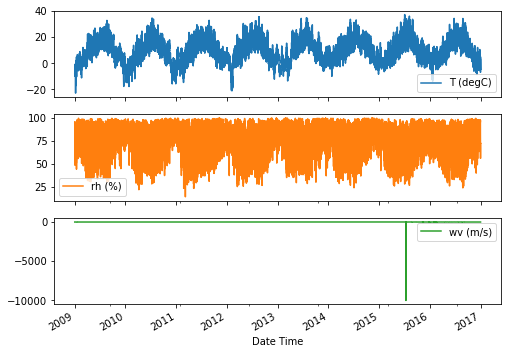

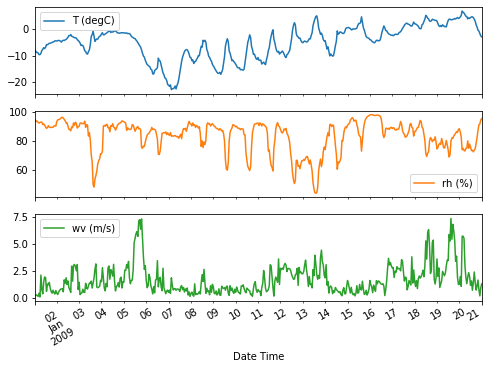

In [5]:
plot_cols = ['T (degC)', 'rh (%)', 'wv (m/s)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

We see two sets of plots above that include the same three pieces of information but on different timescales. We see the temperature, the relative humidity, and the wind velocity. In the first set we see our data across the entire timescale, whereas in the second set we see it on the timescale of a month. There certainly does some to be a structure especially in the temperature and humidity, although we do note a seemingly extraneous piece of information in the wind velocity data.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Here again we see our strange wind information. The minimum is -9999 which is not something that makes physical sense. We will replace this erroneous data with 0.

In [7]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

Before we move on we need to examine and modify our data somewhat. We begin with the wind.

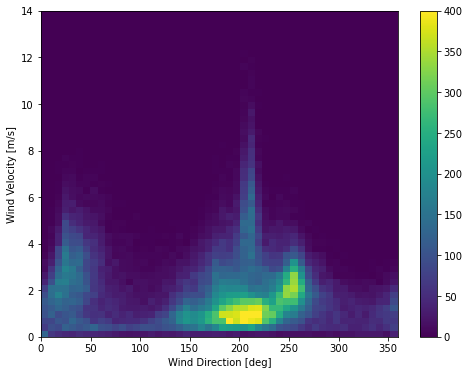

In [8]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]');

This is the current distribution of the wind direction versus velocity. The problem is the direction is measured in degrees which is discontinuous.

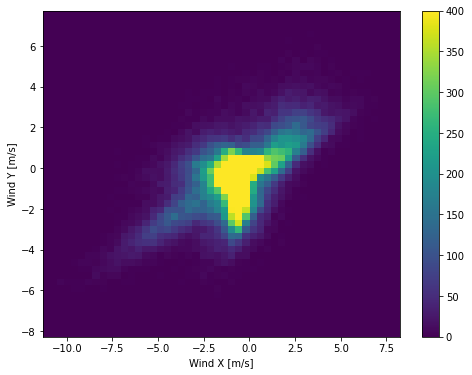

In [9]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight');

We have converted our wind direction to x and y components and we can see the distribution above. Next up time...

In [10]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

We will alter our time data by converting it to seconds and then mapping it to a periodic cos and sin.

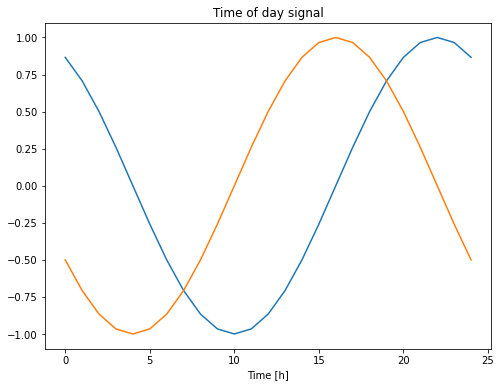

In [11]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal');

To extend this further we will use a fast fourier transform to determine the most important signals for some of our other data.

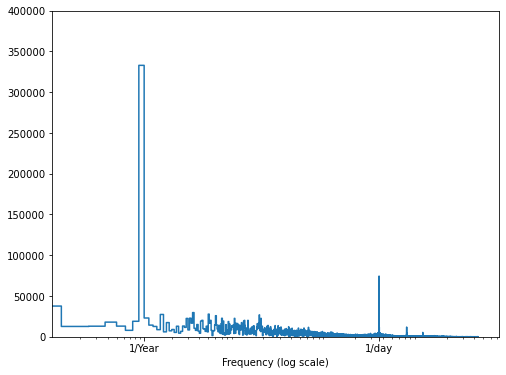

In [12]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

This result should not be all that suprising as we see that the most important signals are the on the year and day period.

Next, we need to set up our dataset of deep learning.

In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Above we have normalized our data. We note that we have not included the validation or test data in this process as we dont want the network having access to that.

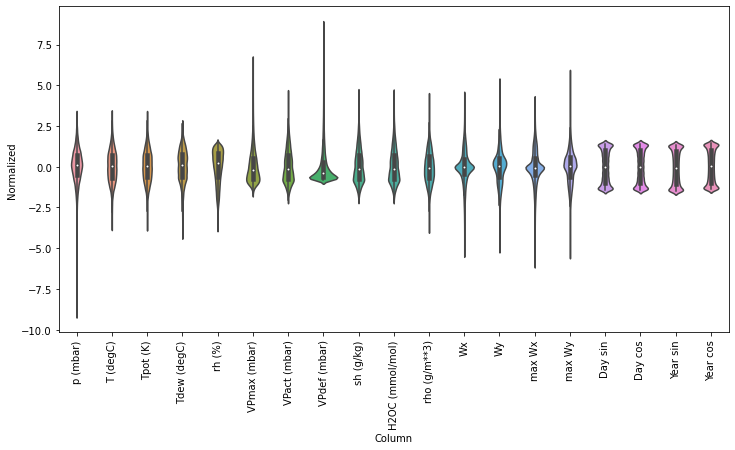

In [15]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

We will be building a variety of models to learn from our data, and we will be predicting a variety of outputs. Because of this we wont a system for data windowing that can be used everywhere.

In [16]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds

The above class will handle all of the windowing for us, and we wont really discuss it too much as it is not central to this exercise. Below is an example of using the window generator to create a window of 24 hours of past history for 24 hours of prediction.

In [17]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

Now we add a few properties for accessing the different sets of data.

In [18]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

With our window generator class all ready to go we can move on to building models and evaluating them.

We will start with predicting a single features value 1 time step forward. We will also create a baseline model whose output is just the current temperature.

In [19]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [20]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


Below we subclass from the Keras model and define the call function as just the identity mapping.

In [21]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

There is no neeed to train the model so we can just go ahead and evaluate.

In [22]:
baseline = Baseline(label_index=column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 2s 4ms/step - loss: 0.0128 - mean_absolute_error: 0.0785


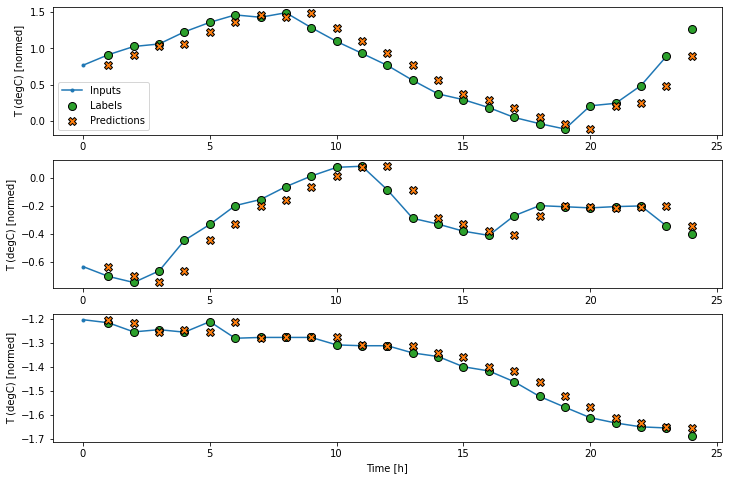

In [23]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window.plot(baseline)

We can see that the baseline model seems to be doing fairly okay. Now we will look at some models with trainable parameters to see if we can do any better. We will begin by defining some reusable code for training our various models.

In [24]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [27]:
#A very simple linear model with no activations
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [28]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.2754 - mean_absolute_error: 0.2866 - val_loss: 0.0111 - val_mean_absolute_error: 0.0784
Epoch 2/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0102 - mean_absolute_error: 0.0748 - val_loss: 0.0096 - val_mean_absolute_error: 0.0730
Epoch 3/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0097 - mean_absolute_error: 0.0724 - val_loss: 0.0092 - val_mean_absolute_error: 0.0715
Epoch 4/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0093 - mean_absolute_error: 0.0708 - val_loss: 0.0089 - val_mean_absolute_error: 0.0698
Epoch 5/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0701 - val_loss: 0.0088 - val_mean_absolute_error: 0.0696
Epoch 6/20
1534/1534 [==============================] - 10s 6ms/step - loss: 0.0092 - mean_absolute_error: 0.0700 - val_loss: 0.0088 - val_mean_absolute_error: 0.0696

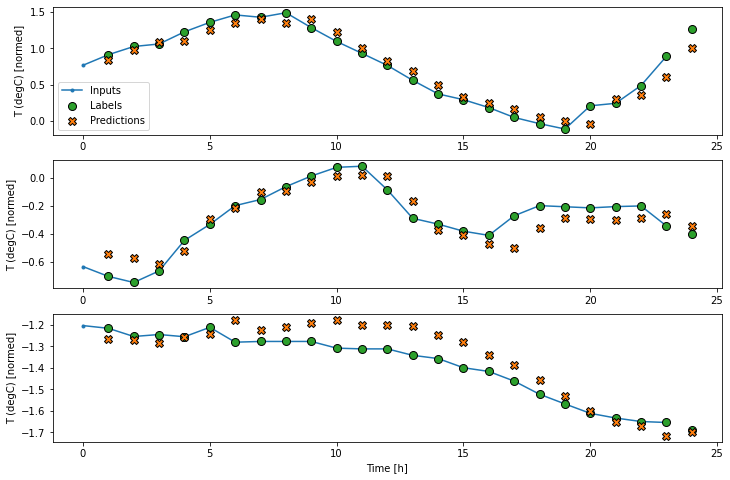

In [29]:
wide_window.plot(linear)

The plain linear model is doing okay, but it definitely appears to be doing worse than the baseline which is not good. We can look at the weight for each input to get an idea of what the network is thinking.

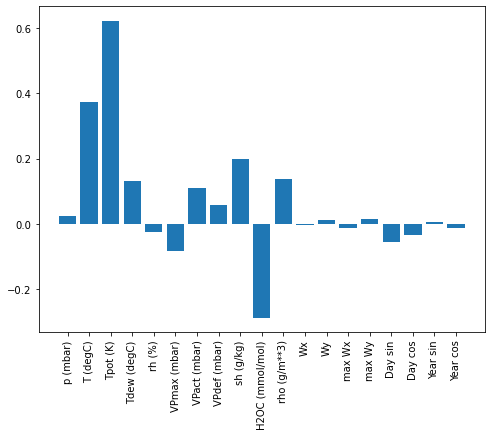

In [30]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

At least we can see that the network recognizes that temperature variables are important.

Lets try a more substantial version of the linear model with non-linear activations and mutltiple layers.

In [32]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0138 - mean_absolute_error: 0.0778 - val_loss: 0.0089 - val_mean_absolute_error: 0.0691
Epoch 2/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0080 - mean_absolute_error: 0.0649 - val_loss: 0.0070 - val_mean_absolute_error: 0.0589
Epoch 3/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0076 - mean_absolute_error: 0.0629 - val_loss: 0.0068 - val_mean_absolute_error: 0.0573
Epoch 4/20
1534/1534 [==============================] - 11s 7ms/step - loss: 0.0073 - mean_absolute_error: 0.0613 - val_loss: 0.0068 - val_mean_absolute_error: 0.0583
Epoch 5/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0071 - mean_absolute_error: 0.0602 - val_loss: 0.0068 - val_mean_absolute_error: 0.0591
Epoch 6/20
439/439 [==============================] - 2s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0620


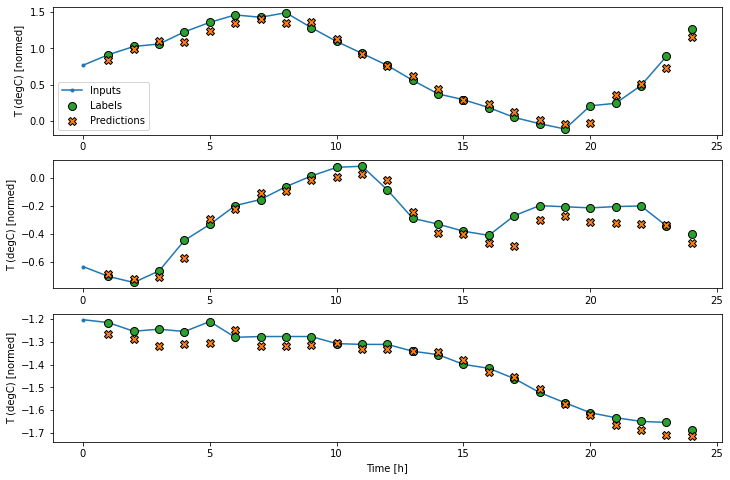

In [33]:
wide_window.plot(dense)

This three layer model is clearly performing better than our basic linear model. Up too now our models have only considered one time step as input. We will try to consider multiple steps for a hopefully more informed prediction.

In [34]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [38]:
multi_step_dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1,-1])
])

In [39]:
history = compile_and_fit(multi_step_dense, conv_window)

val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0275 - mean_absolute_error: 0.1026 - val_loss: 0.0097 - val_mean_absolute_error: 0.0744
Epoch 2/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0083 - mean_absolute_error: 0.0661 - val_loss: 0.0082 - val_mean_absolute_error: 0.0661
Epoch 3/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0616 - val_loss: 0.0069 - val_mean_absolute_error: 0.0596
Epoch 4/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0071 - mean_absolute_error: 0.0598 - val_loss: 0.0069 - val_mean_absolute_error: 0.0602
Epoch 5/20
1534/1534 [==============================] - 9s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0587 - val_loss: 0.0063 - val_mean_absolute_error: 0.0561
Epoch 6/20
1534/1534 [==============================] - 8s 6ms/step - loss: 0.0067 - mean_absolute_error: 0.0578 - val_loss: 0.0063 - val_mean_absolute_error: 0.0559
Epoc

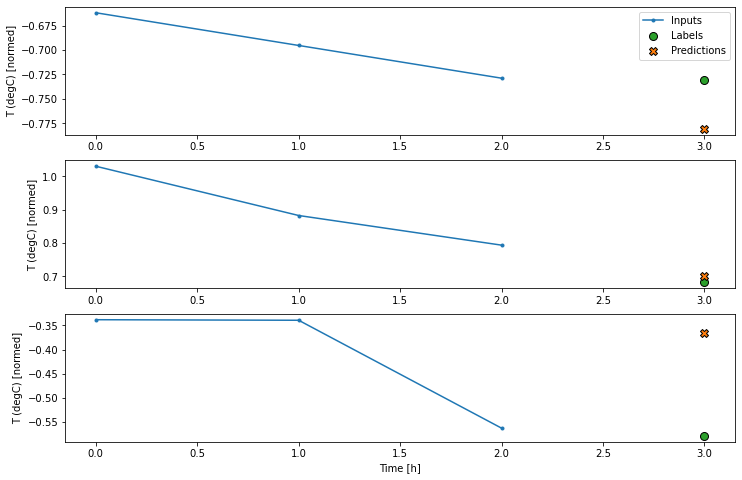

In [40]:
conv_window.plot(multi_step_dense)

Well that doesn't look that good. We can see that the prediction is way off in two of the three examples. Next up we will try a 1-D convolutional network that can operate on any window size.

In [41]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, 
                           kernel_size=(CONV_WIDTH,),
                          activation = 'relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(conv_model, conv_window)

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

Epoch 1/20
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0264 - mean_absolute_error: 0.0982 - val_loss: 0.0088 - val_mean_absolute_error: 0.0693
Epoch 2/20
1534/1534 [==============================] - 13s 9ms/step - loss: 0.0083 - mean_absolute_error: 0.0663 - val_loss: 0.0087 - val_mean_absolute_error: 0.0678
Epoch 3/20
1534/1534 [==============================] - 12s 8ms/step - loss: 0.0075 - mean_absolute_error: 0.0618 - val_loss: 0.0068 - val_mean_absolute_error: 0.0573
Epoch 4/20
1534/1534 [==============================] - 13s 8ms/step - loss: 0.0073 - mean_absolute_error: 0.0609 - val_loss: 0.0082 - val_mean_absolute_error: 0.0665
Epoch 5/20
438/438 [==============================] - 2s 6ms/step - loss: 0.0072 - mean_absolute_error: 0.0596


In [42]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

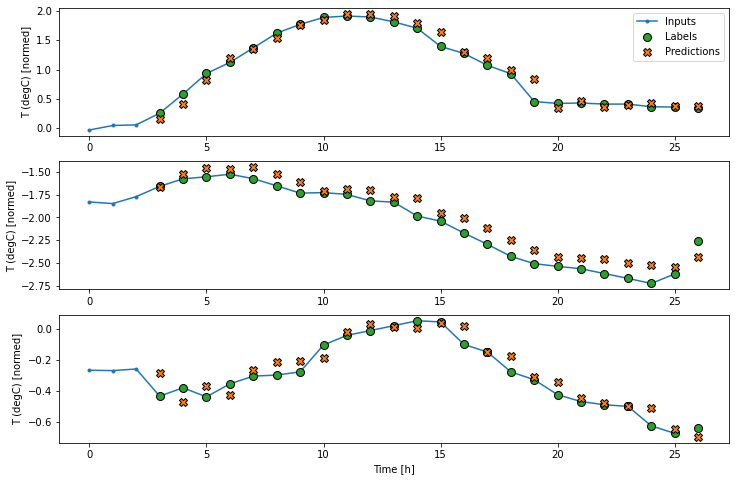

In [43]:
wide_conv_window.plot(conv_model)

In the above plots every prediction is based on the three proceeding time steps and it seems to be doing okay. Finally, we get to the real goal and the nextwork that makes the most sense for this sequential data: a RNN. Our RNN will be using an LSTM layer followed by one dense layer.

In [44]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/20
1533/1533 [==============================] - 16s 10ms/step - loss: 0.0266 - mean_absolute_error: 0.0948 - val_loss: 0.0067 - val_mean_absolute_error: 0.0577
Epoch 2/20
1533/1533 [==============================] - 16s 11ms/step - loss: 0.0065 - mean_absolute_error: 0.0562 - val_loss: 0.0061 - val_mean_absolute_error: 0.0544
Epoch 3/20
1533/1533 [==============================] - 15s 10ms/step - loss: 0.0060 - mean_absolute_error: 0.0536 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525
Epoch 4/20
1533/1533 [==============================] - 15s 10ms/step - loss: 0.0058 - mean_absolute_error: 0.0525 - val_loss: 0.0057 - val_mean_absolute_error: 0.0522
Epoch 5/20
1533/1533 [==============================] - 15s 10ms/step - loss: 0.0057 - mean_absolute_error: 0.0520 - val_loss: 0.0057 - val_mean_absolute_error: 0.0516
Epoch 6/20
1533/1533 [==============================] - 15s 10ms/step - loss: 0.0056 - mean_absolute_error: 0.0514 - val_loss: 0.0056 - val_mean_absolute_error:

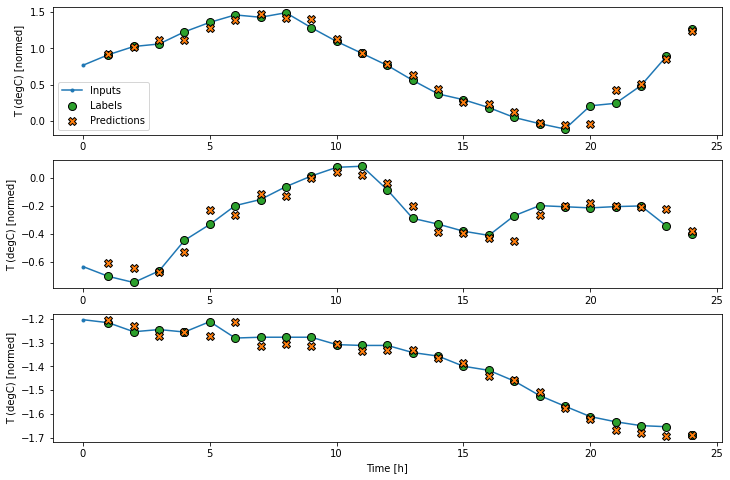

In [45]:
wide_window.plot(lstm_model)

We have seen a lot of models and a lot of graphs showing predictions, but at this point it is difficult to say which model has performed the best. To this end let us look at the comparative performances.

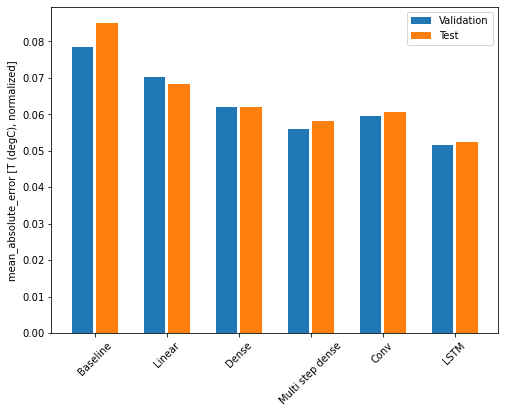

In [46]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

This is about what we expect with increasing performance up until the LSTM model which is the best. The exception to this is the decrease in performance for the convolutional model. Really the multi step dense and the convolutional model are the same except that the multi step has more trainable parameters. The benefit to the convolutional layer being its adaptability to inputs.

We note that we can alter our model structure to predict multiple outputs instead of just temperature. We will not do that here, but we will investigate a residual form of or RNN. The idea behind this is to predict the change from the last timestep instead of the next timesteps value. Initially, the model will just be the baseline but will evolve over time.

In [47]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [48]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

Epoch 1/20
1533/1533 [==============================] - 26s 17ms/step - loss: 0.1533 - mean_absolute_error: 0.2093 - val_loss: 0.0194 - val_mean_absolute_error: 0.0893
Epoch 2/20
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0141 - mean_absolute_error: 0.0790 - val_loss: 0.0105 - val_mean_absolute_error: 0.0698
Epoch 3/20
1533/1533 [==============================] - 26s 17ms/step - loss: 0.0091 - mean_absolute_error: 0.0662 - val_loss: 0.0078 - val_mean_absolute_error: 0.0610
Epoch 4/20
1533/1533 [==============================] - 25s 16ms/step - loss: 0.0075 - mean_absolute_error: 0.0603 - val_loss: 0.0070 - val_mean_absolute_error: 0.0582
Epoch 5/20
1533/1533 [==============================] - 25s 17ms/step - loss: 0.0068 - mean_absolute_error: 0.0576 - val_loss: 0.0065 - val_mean_absolute_error: 0.0560
Epoch 6/20
1533/1533 [==============================] - 25s 16ms/step - loss: 0.0065 - mean_absolute_error: 0.0562 - val_loss: 0.0063 - val_mean_absolute_error:

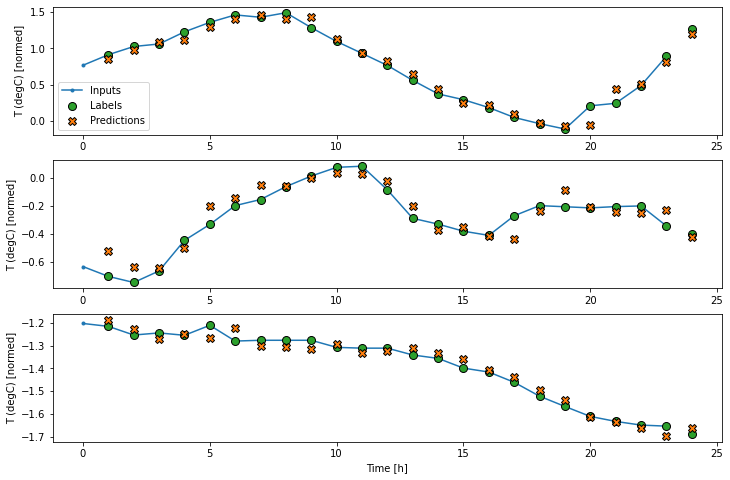

In [49]:
wide_window.plot(residual_lstm)

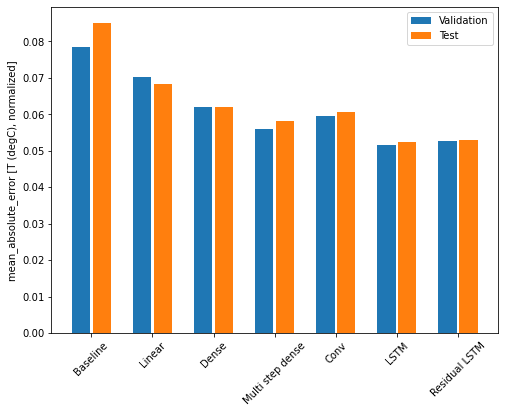

In [50]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

Not too much to discuss here, but just an interesting model type with some good ideas behind it.

We do want to look at multi step models that make predictions for multiple steps into the future. We will first look at a models that predict all the features for all output time steps, and later we will look at an autoregressive version.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

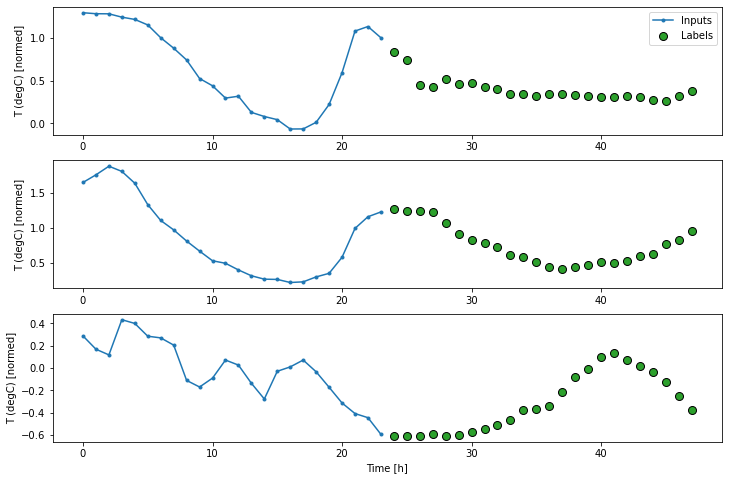

In [51]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

The plots above describe the goal; predict the green dots from the blue input. Just like our previous baseline, the baseline in this case can just predict the last value into the infinite future.

437/437 [==============================] - 1s 2ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


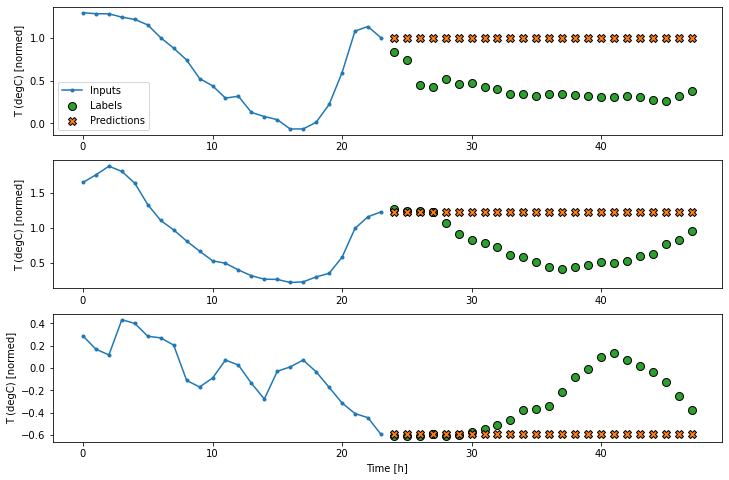

In [52]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

Obviously that is not a very good idea, and clearly it doesn't work that well. We could also have a baseline that just predicts the same exact values but shifted forward in time.

437/437 [==============================] - 1s 2ms/step - loss: 0.4271 - mean_absolute_error: 0.3960


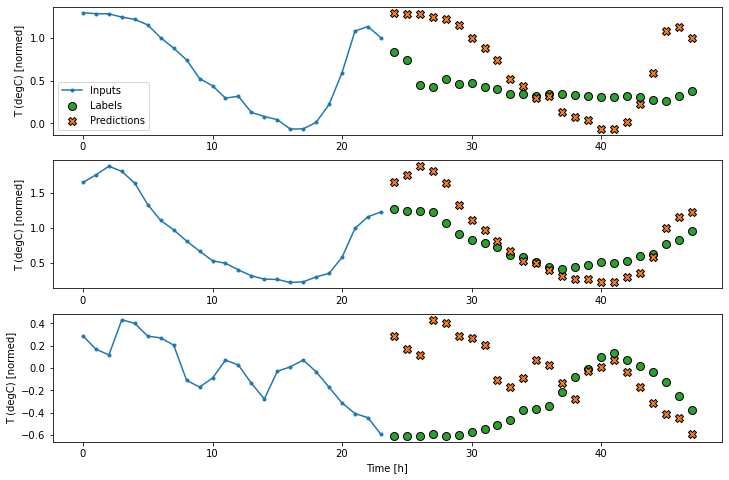

In [53]:
class RepeatBaseline(tf.keras.Model):
    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

Maybe a little better, but still not that good. Our next model is a linear model that predicts all future outputs using only the most recent input.

Epoch 1/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0.3288 - mean_absolute_error: 0.3985 - val_loss: 0.2595 - val_mean_absolute_error: 0.3233
Epoch 2/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0.2576 - mean_absolute_error: 0.3132 - val_loss: 0.2563 - val_mean_absolute_error: 0.3059
Epoch 3/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2567 - mean_absolute_error: 0.3079 - val_loss: 0.2562 - val_mean_absolute_error: 0.3052
Epoch 4/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2566 - mean_absolute_error: 0.3077 - val_loss: 0.2562 - val_mean_absolute_error: 0.3054
Epoch 5/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0.2566 - mean_absolute_error: 0.3077 - val_loss: 0.2560 - val_mean_absolute_error: 0.3053
Epoch 6/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2566 - mean_absolute_error: 0.3077 - val_loss: 0.2561 - val_mean_absolute_error: 0.3053
Epoc

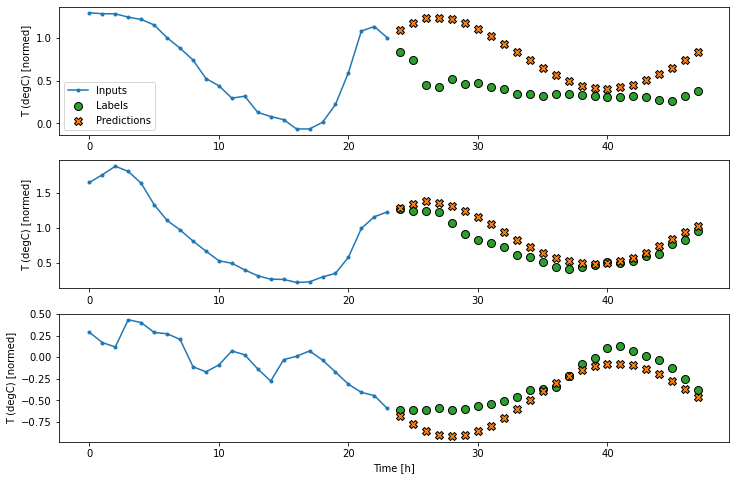

In [55]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

We can see that this already does better than the baselines discussed above. We will now look at the remaining models we investigated earlier, but with this multiple time output prediction.

Epoch 1/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2391 - mean_absolute_error: 0.3010 - val_loss: 0.2256 - val_mean_absolute_error: 0.2887
Epoch 2/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2229 - mean_absolute_error: 0.2852 - val_loss: 0.2229 - val_mean_absolute_error: 0.2848
Epoch 3/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2194 - mean_absolute_error: 0.2822 - val_loss: 0.2202 - val_mean_absolute_error: 0.2825
Epoch 4/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2166 - mean_absolute_error: 0.2797 - val_loss: 0.2199 - val_mean_absolute_error: 0.2825
Epoch 5/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2147 - mean_absolute_error: 0.2783 - val_loss: 0.2195 - val_mean_absolute_error: 0.2817
Epoch 6/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2133 - mean_absolute_error: 0.2772 - val_loss: 0.2177 - val_mean_absolute_error: 0.2797
Epoc

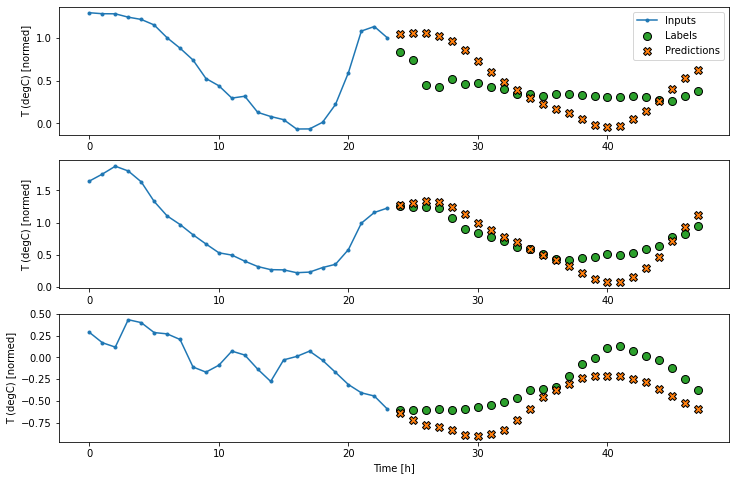

In [57]:
#A Dense model
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

Epoch 1/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0.2387 - mean_absolute_error: 0.3045 - val_loss: 0.2229 - val_mean_absolute_error: 0.2878
Epoch 2/20
1532/1532 [==============================] - 4s 3ms/step - loss: 0.2195 - mean_absolute_error: 0.2859 - val_loss: 0.2204 - val_mean_absolute_error: 0.2868
Epoch 3/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2156 - mean_absolute_error: 0.2824 - val_loss: 0.2185 - val_mean_absolute_error: 0.2844
Epoch 4/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2128 - mean_absolute_error: 0.2800 - val_loss: 0.2176 - val_mean_absolute_error: 0.2855
Epoch 5/20
1532/1532 [==============================] - 5s 3ms/step - loss: 0.2108 - mean_absolute_error: 0.2783 - val_loss: 0.2146 - val_mean_absolute_error: 0.2813
Epoch 6/20
1532/1532 [==============================] - 5s 4ms/step - loss: 0.2091 - mean_absolute_error: 0.2769 - val_loss: 0.2151 - val_mean_absolute_error: 0.2801
Epoc

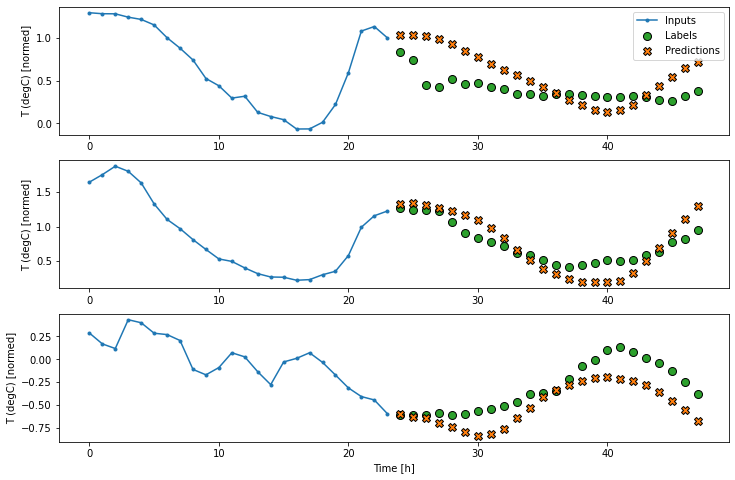

In [58]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

Epoch 1/20
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2914 - mean_absolute_error: 0.3625 - val_loss: 0.2300 - val_mean_absolute_error: 0.3068
Epoch 2/20
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2168 - mean_absolute_error: 0.2949 - val_loss: 0.2208 - val_mean_absolute_error: 0.2957
Epoch 3/20
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2094 - mean_absolute_error: 0.2864 - val_loss: 0.2177 - val_mean_absolute_error: 0.2906
Epoch 4/20
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2055 - mean_absolute_error: 0.2822 - val_loss: 0.2160 - val_mean_absolute_error: 0.2886
Epoch 5/20
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2028 - mean_absolute_error: 0.2795 - val_loss: 0.2158 - val_mean_absolute_error: 0.2877
Epoch 6/20
1532/1532 [==============================] - 6s 4ms/step - loss: 0.2007 - mean_absolute_error: 0.2778 - val_loss: 0.2153 - val_mean_absolute_error: 0.2870
Epoc

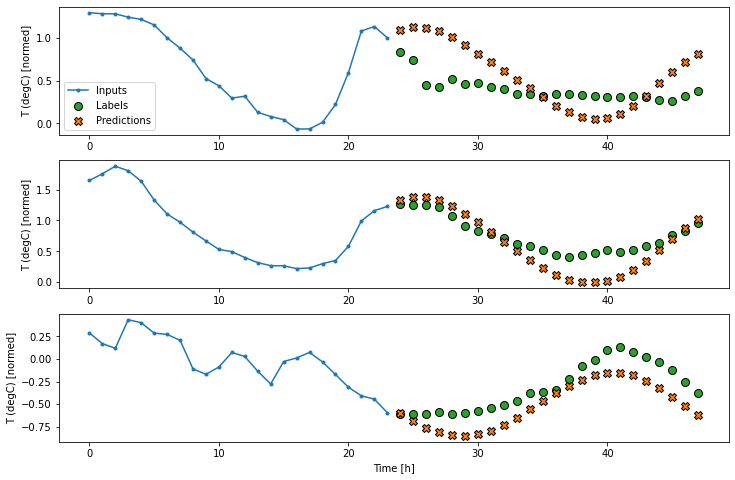

In [59]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

Before we compare performance we want to look at the autoregressive version of our RNN model. 

In [61]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions
        
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

Epoch 1/20
1532/1532 [==============================] - 45s 29ms/step - loss: 0.3032 - mean_absolute_error: 0.3770 - val_loss: 0.2474 - val_mean_absolute_error: 0.3283
Epoch 2/20
1532/1532 [==============================] - 45s 30ms/step - loss: 0.2331 - mean_absolute_error: 0.3155 - val_loss: 0.2400 - val_mean_absolute_error: 0.3166
Epoch 3/20
1532/1532 [==============================] - 50s 33ms/step - loss: 0.2243 - mean_absolute_error: 0.3056 - val_loss: 0.2385 - val_mean_absolute_error: 0.3134
Epoch 4/20
1532/1532 [==============================] - 46s 30ms/step - loss: 0.2197 - mean_absolute_error: 0.3004 - val_loss: 0.2292 - val_mean_absolute_error: 0.3067
Epoch 5/20
1532/1532 [==============================] - 48s 31ms/step - loss: 0.2153 - mean_absolute_error: 0.2962 - val_loss: 0.2316 - val_mean_absolute_error: 0.3078
Epoch 6/20
437/437 [==============================] - 3s 6ms/step - loss: 0.2294 - mean_absolute_error: 0.3038


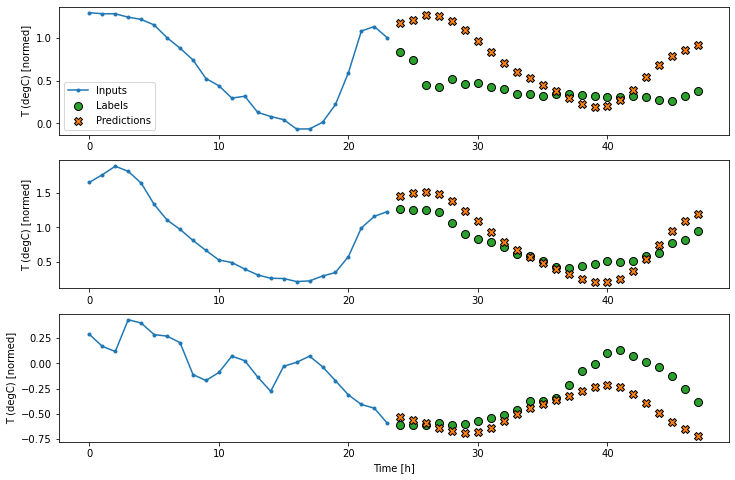

In [62]:
history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

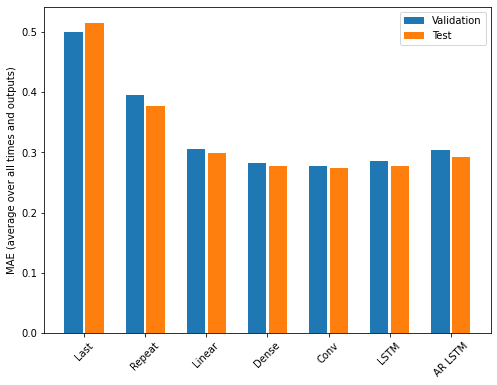

In [63]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

Now we see the performance of all of our models, and we note that this is error averaged over all time and outputs. In this case it seems that the error begins to pick up after the convolutional model. This is a little suprising, as I would have expected the autoregressive model to contain more information and thus perform better. I think more investigation would be needed to fully understand the situation here, but suffice to say it is not always clear cut.